In [30]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt
import random


In [4]:
# from matplotlib import cm
# import vcf
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines
# import statistics
# import allel
# from collections import defaultdict
# from itertools import combinations
# from haversine import haversine
# from skbio.stats.distance import mantel
# from scipy.stats import ttest_ind
# import random
# import time
# import multiprocessing as mp
# from matplotlib.colors import ListedColormap
# from IPython.display import Image


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

In [3]:
os.chdir(proj_dir)

In [4]:
#now add sample info (including location data)
info_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
info_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.173881,0.026648,0.002356,0.003491,0.040333,0.056209,0.034671,-0.018987,0.006714,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173042,0.026219,0.002305,0.004889,0.041296,0.059342,0.034267,-0.018533,0.003969,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.173645,0.026263,0.002368,0.000767,0.042174,0.060543,0.032764,-0.020686,0.002916,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.172982,0.026137,0.003690,-0.002314,0.042092,0.059532,0.033454,-0.014835,0.000759,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.172250,0.026551,0.002041,0.004355,0.042407,0.059827,0.033576,-0.020790,0.009542,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026690,-0.083394,-0.003446,-0.070261,-0.010403,-0.085303,0.096133,-0.115088,0.082561,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [5]:
Path(f"{results_dir}/zw_cov").mkdir(parents=True, exist_ok=True)

os.chdir(f"{results_dir}/zw_cov")

In [7]:
%%bash 

echo -e """NC_067195.1\t0\t10000000
NC_067195.1\t10000000\t45000000
NC_067195.1\t45000000\t89168492""">par.bed

In [9]:
!conda run -n bcftools bcftools query -l ../filter_genotypes/sorted_annotated_snps.vcf >samples.list

In [11]:
!conda run -n bedtools bedtools makewindows -g ../../data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai -w 10000 | grep NC_067195.1 >zw_windows.bed

In [20]:
%%bash

GENOME="/master/nplatt/sch_hae_scan/data/GCF_000699445.3_UoM_Shae.V3_genomic.fna"

for SAMPLE in $(cat samples.list); do
    #echo $SAMPLE
    
    BAM="/master/nplatt/sch_hae_scan/results/mapped_reads/${SAMPLE}_processed.cram"

    WINDOW_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 4 -N ${SAMPLE}.windows -o ${SAMPLE}.windows.log" 
    WINDOW_CMD="conda run -n mosdepth mosdepth -t 4 -b windows.bed -f ${GENOME} -n ${SAMPLE}.windows.mean ${BAM}"
    echo $WINDOW_CMD | $WINDOW_QSUB

    PAR_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 -N ${SAMPLE}.par -o ${SAMPLE}.par.log" 
    PAR_CMD="conda run -n mosdepth mosdepth -t 1 -b par.bed -f ${GENOME} -n ${SAMPLE}.par.mean ${BAM}"
    echo $PAR_CMD | $PAR_QSUB

    GENOME_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 4 -N ${SAMPLE}.par -o ${SAMPLE}.genome.log" 
    GENOME_CMD="conda run -n mosdepth mosdepth -t 4 -f ${GENOME} -n ${SAMPLE}.genome.mean $BAM"
    echo $GENOME_CMD | $GENOME_QSUB

done

Your job 1322880 ("Sb_NG_au_1.2.windows") has been submitted
Your job 1322881 ("Sb_NG_au_1.2.par") has been submitted
Your job 1322882 ("Sb_NG_au_1.2.par") has been submitted
Your job 1322883 ("Sb_NG_au_2.10.windows") has been submitted
Your job 1322884 ("Sb_NG_au_2.10.par") has been submitted
Your job 1322885 ("Sb_NG_au_2.10.par") has been submitted
Your job 1322886 ("Sb_NG_au_2.13.windows") has been submitted
Your job 1322887 ("Sb_NG_au_2.13.par") has been submitted
Your job 1322888 ("Sb_NG_au_2.13.par") has been submitted
Your job 1322889 ("Sb_NG_au_2.5.windows") has been submitted
Your job 1322890 ("Sb_NG_au_2.5.par") has been submitted
Your job 1322891 ("Sb_NG_au_2.5.par") has been submitted
Your job 1322892 ("Sb_NG_au_2.6.windows") has been submitted
Your job 1322893 ("Sb_NG_au_2.6.par") has been submitted
Your job 1322894 ("Sb_NG_au_2.6.par") has been submitted
Your job 1322895 ("Sb_NG_be_1.10.windows") has been submitted
Your job 1322896 ("Sb_NG_be_1.10.par") has been submitted

In [ ]:
# Load the samples list and select random ones to plot
samples = list(info_df.loc[info_df["pca_species"] == "s_haematobium"]["sample_name"])
random_samples = random.sample(samples, 20)

# Calculate the number of rows needed for three columns
n_cols = 6
n_rows = (len(random_samples) + n_cols - 1) // n_cols  # Ensures enough rows to handle all samples

# Prepare the figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_rows, 6 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, sample in zip(axes, random_samples):
    bed_file = f"{sample}.windows.mean.regions.bed.gz"
    par_file = f"{sample}.par.mean.regions.bed.gz"

    # Load data
    df = pd.read_csv(bed_file, sep='\t', header=None,
                     names=['chrom', 'start', 'end', 'cov'],
                     dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    par_df = pd.read_csv(par_file, sep='\t', header=None,
                         names=['chrom', 'start', 'end', 'cov'],
                         dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    # Apply median filter
    filtered_data = medfilt(df["cov"], kernel_size=101)

    # Plot filtered data
    ax.scatter(df["start"], filtered_data, s=3, color="grey", alpha=1)

    # Highlight PAR regions
    for index, row in par_df.iterrows():
        ax.plot([row['start'], row['end']], [row['cov'], row['cov']], color="red", linewidth=3)

    z=par_df.iloc[1]
    ax.plot([z['start'], z['end']], [z['cov'], z['cov']], color="blue", linewidth=3)

    # Set labels and title for each subplot
    ax.set_xlabel("ChrZW", size=12)
    ax.set_ylabel("Coverage", size=12)
    ax.set_title(f"{sample}", y=0.93)

# Hide any unused axes if the number of samples isn't a multiple of three
for ax in axes[len(samples):]:
    ax.axis('off')

# Display the figure with all subplots
plt.tight_layout()  # Adjust layout to prevent overlap

plt.savefig("zw_cov.png", facecolor="white", dpi=600)
#plt.savefig("zw_cov.svg")

plt.show()


/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data = medfilt(df["cov"], kernel_size=101)
/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data = medfilt(df["cov"], kernel_size=101)
/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data = medfilt(df["cov"], kernel_size=101)
/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data = medfilt(df["cov"], kernel_size=101)
/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data = medfilt(df["cov"], kernel_size=101)
/tmp/ipykernel_340198/134113779.py:27: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  filtered_data 

In [ ]:
# Assume 'samples' is already defined and loaded
samples = pd.read_csv("samples.list", header=None)
samples = list(samples[0])

# Initialize an empty list to store data
summary_data = []

for sample in samples:
    summary_file = f"{sample}.genome.mean.mosdepth.summary.txt"
    par_file = f"{sample}.par.mean.regions.bed.gz"

    # Load data
    summary_df = pd.read_csv(summary_file, sep='\t', header=0)
    par_df = pd.read_csv(par_file, sep='\t', header=None,
                         names=['chrom', 'start', 'end', 'cov'],
                         dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    # Extracting necessary data
    genome_mean = summary_df.loc[summary_df["chrom"] == "total", "mean"].values[0]
    chr_zw_mean = summary_df.loc[summary_df["chrom"] == "NC_067195.1", "mean"].values[0]
    par1_mean = par_df.iloc[0]["cov"]
    z_mean = par_df.iloc[1]["cov"]
    par2_mean = par_df.iloc[2]["cov"]

    # Append data to the list as a dictionary
    summary_data.append({
        'sample': sample,
        'genome_mean': genome_mean,
        'chr_zw_mean': chr_zw_mean,
        'par1_mean': par1_mean,
        'z_mean': z_mean,
        'par2_mean': par2_mean
    })

# Create DataFrame from the list of dictionaries
summary_df = pd.DataFrame(summary_data)

summary_df


In [151]:
summary_df["ratio"] = summary_df["z_mean"] / ((summary_df["par1_mean"] + summary_df["par2_mean"])/2)
summary_df["sex"] = "male"
summary_df.loc[summary_df["ratio"] < 0.67, "sex"] = "female"

summary_df.to_csv("zw_cov_df.csv", sep=",", header=True, index=False)
summary_df

,sample,genome_mean,chr_zw_mean,par1_mean,z_mean,par2_mean,ratio,sex
0,mw_31,20.32,17.03,23.33,11.70,19.82,0.542294,female
1,sha_niger_libore_148,52.70,41.94,44.13,27.22,53.11,0.559852,female
2,sha_kenya_unk_49,23.77,19.17,19.36,11.77,24.99,0.530778,female
3,mw_35,20.72,17.14,21.57,11.30,20.76,0.533900,female
4,mw_33,29.34,24.40,31.77,16.37,29.10,0.537868,female
5,sha_swaz_mkhuzweni_178,47.08,39.67,45.80,27.61,47.84,0.589705,female
6,mw_28,105.97,86.54,101.01,59.11,104.99,0.573883,female
7,mw_25a,43.11,37.31,43.60,27.29,43.82,0.624342,female
8,mw_27,84.04,70.10,84.21,43.58,87.93,0.506332,female
9,mw_26,62.76,52.03,68.19,34.58,62.19,0.530449,female


In [155]:
summary_df = summary_df.sort_values("sex").reset_index(drop=True)

In [9]:
summary_df=pd.read_csv("zw_cov_df.csv", header=0, sep=",")
summary_df.head()

,sample,genome_mean,chr_zw_mean,par1_mean,z_mean,par2_mean,ratio,sex
0,mw_31,20.32,17.03,23.33,11.70,19.82,0.542294,female
1,sha_niger_libore_148,52.70,41.94,44.13,27.22,53.11,0.559852,female
2,sha_kenya_unk_49,23.77,19.17,19.36,11.77,24.99,0.530778,female
3,mw_35,20.72,17.14,21.57,11.30,20.76,0.533900,female
4,mw_33,29.34,24.40,31.77,16.37,29.10,0.537868,female


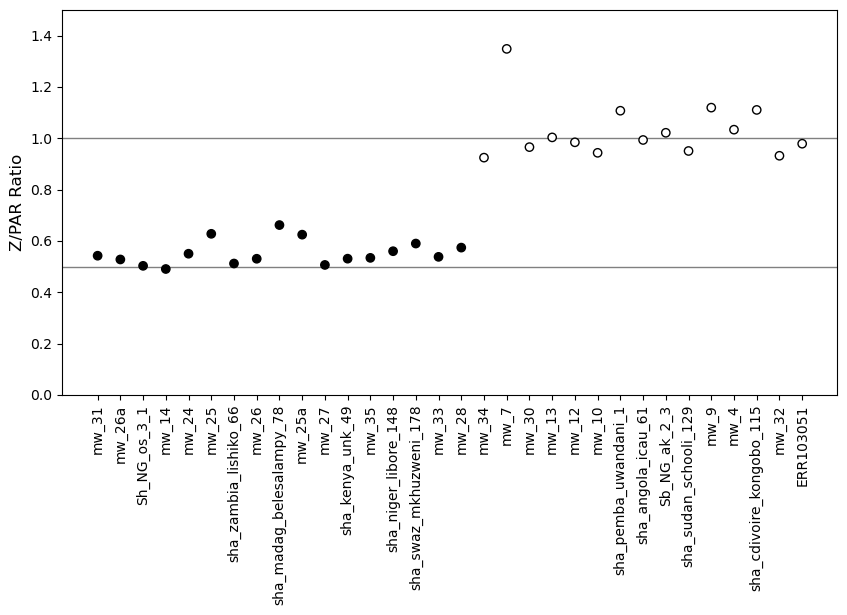

In [165]:
# Color mapping based on sex
colors = summary_df['sex'].map({'male': 'white', 'female': 'black'})

# Plot
plt.figure(figsize=(10, 5))
plt.axhline(y=1, color='grey', label='y = 1', linewidth=1)
plt.axhline(y=0.5, color='grey', label='y = 0.5', linewidth=1)

# Scatter plot with colors based on sex using the 'c' parameter
plt.scatter(range(0, len(summary_df['ratio'])), summary_df['ratio'], c=colors, zorder=5, edgecolors="black")

# Set x-ticks to sample names, rotated 90 degrees
plt.xticks(summary_df.index, summary_df['sample'], rotation=90)

# Setting the y-axis limits
plt.ylim([0, 1.5])
plt.ylabel("Z/PAR Ratio", size=12)

plt.savefig("zw_ratio.png", facecolor="white", dpi=600)
plt.savefig("zw_ratio.svg")

# Show plot
plt.show()


In [169]:
summary_df.loc[summary_df["sex"] == "female", "sample"].to_csv("females.list", sep=",", header=False, index=False)
summary_df.loc[summary_df["sex"] == "male", "sample"].to_csv("males.list", sep=",", header=False, index=False)